In [ ]:
import pandas as pd
from google.colab import files

uploaded = files.upload()

Saving evaluation_with_fire_and_coordinates_and_date.csv to evaluation_with_fire_and_coordinates_and_date.csv
Saving weather_with_station_names.csv to weather_with_station_names.csv


In [ ]:
#Load weather data
weather = pd.read_csv('weather_with_station_names.csv')
weather['Date'] = pd.to_datetime(weather['time'])

#Extract Year and Month
weather['Year'] = weather['Date'].dt.year
weather['Month'] = weather['Date'].dt.month

#Monthly aggregation
monthly_weather = weather.groupby(['Year', 'Month']).agg({
    'temperature_2m_mean (°C)': 'mean',
    'temperature_2m_max (°C)': 'mean',
    'temperature_2m_min (°C)': 'mean',
    'wind_speed_10m_mean (km/h)': 'mean',
    'wind_gusts_10m_mean (km/h)': 'mean'
}).reset_index()
monthly_weather.head()

,Year,Month,temperature_2m_mean (°C),temperature_2m_max (°C),temperature_2m_min (°C),wind_speed_10m_mean (km/h),wind_gusts_10m_mean (km/h)
0,2014,1,-10.361022,-6.040323,-14.492742,14.373118,28.619624
1,2014,2,-9.120833,-5.490476,-12.737202,13.094345,25.363393
2,2014,3,-6.850000,-2.094624,-11.679839,13.680645,27.173387
3,2014,4,5.015833,9.893889,0.260556,14.183333,29.846111
4,2014,5,13.312634,18.237366,8.715054,12.621505,26.998925


In [ ]:
#Load evaluation data and rename fire column
eval_df = pd.read_csv('evaluation_with_fire_and_coordinates_and_date.csv')
eval_df = eval_df.rename(columns={'fire': 'HAS_FIRE'})

#Convert fire_date, but do NOT drop rows where it's missing
eval_df['Date'] = pd.to_datetime(eval_df['fire_date'], errors='coerce')

#Assign Year and Month even to non-fire records
#fire rows get actual year/month
#non-fire rows get placeholder (Jan 2022)
eval_df['Year'] = eval_df['Date'].dt.year.fillna(2022).astype(int)
eval_df['Month'] = eval_df['Date'].dt.month.fillna(1).astype(int)

In [ ]:
merged_df = pd.merge(eval_df, monthly_weather, on=['Year', 'Month'], how='left')
merged_df = merged_df.dropna(subset=['temperature_2m_mean (°C)'])

# Confirm that both True and False fire records are now present
print(merged_df['HAS_FIRE'].value_counts())

HAS_FIRE
False    369016
True     294767
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

#Define features and target
features = [
    'temperature_2m_mean (°C)',
    'temperature_2m_max (°C)',
    'temperature_2m_min (°C)',
    'wind_speed_10m_mean (km/h)',
    'wind_gusts_10m_mean (km/h)'
]
target = 'HAS_FIRE'

X = merged_df[features]
y = merged_df[target]

#Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#Train Random Forest with class_weight='balanced'
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

#Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred, labels=[False, True]))

              precision    recall  f1-score   support

       False       0.99      1.00      0.99     73803
        True       1.00      0.99      0.99     58954

    accuracy                           0.99    132757
   macro avg       0.99      0.99      0.99    132757
weighted avg       0.99      0.99      0.99    132757

[[73803     0]
 [  834 58120]]


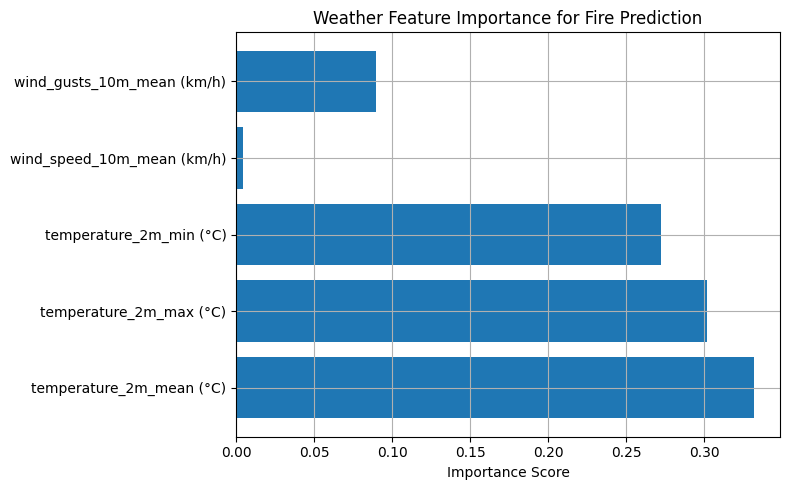

In [ ]:
import matplotlib.pyplot as plt

importances = model.feature_importances_

plt.figure(figsize=(8, 5))
plt.barh(features, importances)
plt.title("Weather Feature Importance for Fire Prediction")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
X_test['HAS_FIRE_actual'] = y_test.values
X_test['HAS_FIRE_predicted'] = y_pred
X_test.to_csv("fire_predictions_weather_only.csv", index=False)